In [250]:
from process_data import clean_data, create_index, pivot_data
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [259]:
df = pivot_data('../data/Data.txt')
df = clean_data(df)
df = create_index(df)

list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))


/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype timedelta64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [264]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)

def create_data_matrix(df):
    temp = df.copy()
    print(temp.shape)
    temp = temp.drop('TRADEDATE',axis=1)
    temp = temp.drop('RTENERGY',axis=1)
    #temp.hourofday = temp.hourofday.dt.seconds/3600
    
    y = temp.pop('DAENERGY').values
    
    #print(temp.shape)
    X = temp.values[:,1:]
    X,y = data_lstm(X,y,48)
    return X,y


def create_rnn():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(49,139), units=64))
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=32,
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        units=16,
        return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print('compilation time : {}'.format(time.time() - start))
    return model
        

In [265]:
X,y = create_data_matrix(df)

(2832, 143)


In [266]:
X.shape

(2784, 49, 139)

In [267]:
y.shape

(2784,)

In [268]:
model = create_rnn()

compilation time : 0.029720067977905273


In [269]:
X_train = X[:-24]
y_train = y[:-24]

In [270]:
model.fit(X_train,y_train, batch_size=32,  #168
        epochs=5,
        validation_split=0.05)

Train on 2622 samples, validate on 138 samples
Epoch 1/5
2622/2622 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0039
Epoch 2/5
2622/2622 [==============================] - 33s - loss: 0.0083 - val_loss: 0.0042
Epoch 3/5
2622/2622 [==============================] - 33s - loss: 0.0061 - val_loss: 0.0030
Epoch 4/5
2622/2622 [==============================] - 32s - loss: 0.0052 - val_loss: 0.0026
Epoch 5/5
2622/2622 [==============================] - 33s - loss: 0.0047 - val_loss: 0.0042


In [271]:
model.predict(X[-24:].reshape(24,49,139))

array([[ 0.07947861],
       [ 0.08130617],
       [ 0.0843255 ],
       [ 0.08851273],
       [ 0.09375663],
       [ 0.09995131],
       [ 0.10687818],
       [ 0.11402007],
       [ 0.12038583],
       [ 0.12472471],
       [ 0.12631631],
       [ 0.12509313],
       [ 0.12159835],
       [ 0.11659179],
       [ 0.11062783],
       [ 0.10427897],
       [ 0.09789108],
       [ 0.09174454],
       [ 0.08640367],
       [ 0.08246373],
       [ 0.08032475],
       [ 0.08009733],
       [ 0.08180559],
       [ 0.08375129]], dtype=float32)

In [273]:
new_results = list_scalers['DAENERGY'].inverse_transform(model.predict(X[-24:].reshape(24,49,139)))

In [278]:
real = list_scalers['DAENERGY'].inverse_transform(df['2017-10-30']['DAENERGY'].values.reshape(-1,1))

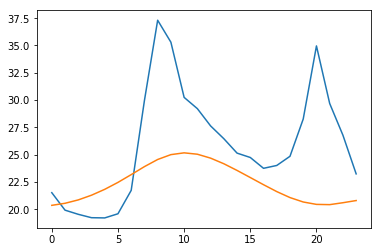

In [280]:
plt.plot(real)
plt.plot(new_results,'-')

In [282]:
y_pred = np.array([[ 21.22765541],
       [ 21.24890518],
       [ 20.74458504],
       [ 20.4667263 ],
       [ 20.29395294],
       [ 20.14176559],
       [ 20.07824516],
       [ 20.15032196],
       [ 20.4307251 ],
       [ 21.09564781],
       [ 22.21565819],
       [ 23.67799759],
       [ 25.33210373],
       [ 27.03659058],
       [ 28.62421417],
       [ 29.85434532],
       [ 30.47985077],
       [ 30.160923  ],
       [ 28.8971405 ],
       [ 27.19917107],
       [ 25.73035049],
       [ 24.61573029],
       [ 23.82040787],
       [ 23.22833252]])
                  

In [283]:
y_true = np.array([[ 17.69],
       [ 15.88],
       [ 13.99],
       [ 12.93],
       [ 12.63],
       [ 12.22],
       [ 13.49],
       [ 15.12],
       [ 16.1 ],
       [ 17.17],
       [ 19.35],
       [ 20.06],
       [ 20.9 ],
       [ 21.09],
       [ 21.81],
       [ 22.08],
       [ 23.62],
       [ 23.95],
       [ 25.21],
       [ 25.12],
       [ 27.83],
       [ 27.29],
       [ 22.69],
       [ 19.82]])

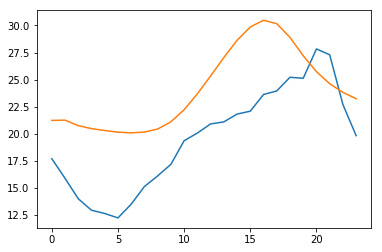

In [286]:
plt.plot(y_true)
plt.plot(y_pred)

In [47]:
X_test = np.array([[11,22,33],[21,22,23],[31,32,33],[41,42,43]])
y_test = np.array([1,2,3,4])

In [48]:
X_test

array([[11, 22, 33],
       [21, 22, 23],
       [31, 32, 33],
       [41, 42, 43]])

In [65]:
x,y =data_lstm(X_test,y_test,1)


In [66]:
x


array([[[11, 22, 33],
        [21, 22, 23]],

       [[21, 22, 23],
        [31, 32, 33]],

       [[31, 32, 33],
        [41, 42, 43]]])

In [67]:
x.shape

(3, 2, 3)

In [64]:
y

array([4])

In [70]:
X.shape

(2831, 2, 141)

In [127]:
X_test

array([[11, 22, 33],
       [21, 22, 23],
       [31, 32, 33],
       [41, 42, 43]])

In [128]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)


In [135]:
X_test[len(X_test)-1-1:len(X_test),:]

array([[31, 32, 33],
       [41, 42, 43]])

In [133]:
x

array([[[11, 22, 33],
        [21, 22, 23]],

       [[21, 22, 23],
        [31, 32, 33]],

       [[31, 32, 33],
        [41, 42, 43]]])

In [139]:
df[:'2017-07-06']

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00
2017-07-05 06:00:00,2017-07-05,78,59,62,68,74,78,70,79,62,...,76,69,61,64,66135,19.20,19.00,2486.072,13300,06:00:00
2017-07-05 07:00:00,2017-07-05,79,61,64,70,74,78,73,78,65,...,77,71,64,67,69477,20.54,19.67,2220.542,13300,07:00:00
2017-07-05 08:00:00,2017-07-05,80,63,66,73,74,80,76,79,70,...,82,74,68,71,74696,22.09,21.09,1671.153,13300,08:00:00
2017-07-05 09:00:00,2017-07-05,81,67,67,76,78,83,77,81,75,...,87,76,73,76,80208,24.33,22.69,1169.623,13300,09:00:00


In [140]:
x


array([[[11, 22, 33],
        [21, 22, 23]],

       [[21, 22, 23],
        [31, 32, 33]],

       [[31, 32, 33],
        [41, 42, 43]]])

In [141]:
x[-1]


array([[31, 32, 33],
       [41, 42, 43]])

In [148]:


date_predict = '2017-10-01'
date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

df_predict = df.copy()
df_predict = df_predict[:date_predict]

df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
df_predict = df_predict[date_start:]

y = df_predict.pop('DAENERGY').values
X = df_predict.values[:,1:]
X,y = data_lstm(X,y,168)

input_p = X[-24:]


In [149]:
input_p.shape

(24, 169, 139)

In [150]:
df_predict

REGION,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,KAMA,...,KUES,KUNV,KVCT,KWRI,KYNG,KZZV,LOAD,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-08-20 00:00:00,168,70,60,69,82,88,75,88,64,76,...,64,63,85,73,62,65,77642,4476.290,18520,0.0
2017-08-20 01:00:00,1,59,61,66,80,87,70,86,69,74,...,70,62,84,68,66,69,76642,2894.985,15750,1.0
2017-08-20 02:00:00,2,66,58,67,80,86,73,85,62,74,...,63,61,83,71,60,64,68781,5026.461,18520,2.0
2017-08-20 03:00:00,3,64,57,67,78,85,72,85,62,73,...,62,60,82,70,60,63,66274,5184.320,18520,3.0
2017-08-20 04:00:00,4,62,57,66,77,84,71,83,61,72,...,62,59,80,70,59,62,64376,5115.629,18520,4.0
2017-08-20 05:00:00,5,63,57,63,76,82,69,84,60,70,...,61,57,79,67,58,60,63317,4949.865,18520,5.0
2017-08-20 06:00:00,6,61,57,63,75,80,69,83,60,69,...,61,57,78,67,59,60,62660,4646.820,18520,6.0
2017-08-20 07:00:00,7,60,60,66,75,80,71,82,63,69,...,62,59,78,69,61,62,63028,4318.929,18520,7.0
2017-08-20 08:00:00,8,61,63,69,76,82,73,85,68,71,...,65,63,82,71,65,65,63755,4025.476,18520,8.0


In [151]:
input_p

array([[[  5.10000000e+01,   6.00000000e+01,   6.70000000e+01, ...,
           6.32062700e+03,   3.25000000e+04,   0.00000000e+00],
        [  4.80000000e+01,   6.20000000e+01,   7.00000000e+01, ...,
           4.65694000e+03,   3.21900000e+04,   1.00000000e+00],
        [  5.10000000e+01,   5.90000000e+01,   6.60000000e+01, ...,
           6.37657100e+03,   3.25000000e+04,   2.00000000e+00],
        ..., 
        [  6.00000000e+01,   4.10000000e+01,   5.00000000e+01, ...,
           9.29259300e+03,   3.48200000e+04,   2.20000000e+01],
        [  5.90000000e+01,   4.00000000e+01,   4.80000000e+01, ...,
           9.87331200e+03,   3.48200000e+04,   2.30000000e+01],
        [  5.90000000e+01,   3.90000000e+01,   4.70000000e+01, ...,
           1.01599550e+04,   3.89300000e+04,   0.00000000e+00]],

       [[  4.80000000e+01,   6.20000000e+01,   7.00000000e+01, ...,
           4.65694000e+03,   3.21900000e+04,   1.00000000e+00],
        [  5.10000000e+01,   5.90000000e+01,   6.60000000e+0

In [165]:
input_p[0,:,2]

array([ 67.,  70.,  66.,  65.,  65.,  64.,  65.,  67.,  71.,  76.,  82.,
        85.,  87.,  88.,  89.,  89.,  89.,  86.,  82.,  78.,  75.,  74.,
        73.,  72.,  71.,  68.,  69.,  69.,  68.,  67.,  68.,  69.,  73.,
        78.,  83.,  86.,  88.,  89.,  90.,  90.,  89.,  86.,  81.,  78.,
        75.,  73.,  72.,  71.,  69.,  67.,  67.,  67.,  66.,  66.,  66.,
        68.,  71.,  75.,  80.,  83.,  86.,  87.,  88.,  88.,  87.,  85.,
        80.,  77.,  74.,  72.,  71.,  69.,  68.,  71.,  67.,  66.,  66.,
        67.,  66.,  68.,  71.,  75.,  79.,  83.,  85.,  87.,  88.,  88.,
        87.,  85.,  80.,  78.,  75.,  74.,  72.,  72.,  71.,  51.,  70.,
        68.,  67.,  66.,  64.,  64.,  65.,  66.,  68.,  70.,  71.,  72.,
        72.,  72.,  70.,  68.,  64.,  61.,  58.,  57.,  55.,  54.,  53.,
        54.,  51.,  50.,  49.,  48.,  47.,  49.,  54.,  58.,  61.,  64.,
        66.,  67.,  68.,  68.,  67.,  64.,  61.,  59.,  57.,  57.,  56.,
        56.,  55.,  47.,  53.,  52.,  51.,  51.,  5

In [166]:
model.predict(input_p)

array([[ 9.53247166],
       [ 9.53247356],
       [ 9.52987194],
       [ 9.52775288],
       [ 9.52741146],
       [ 9.52736759],
       [ 9.52736187],
       [ 9.52736187],
       [ 9.52736187],
       [ 9.52735043],
       [ 9.52274036],
       [ 9.52272701],
       [ 9.52272511],
       [ 9.5227232 ],
       [ 9.52272224],
       [ 9.52272034],
       [ 9.52271938],
       [ 9.52271748],
       [ 9.52271557],
       [ 9.52271366],
       [ 9.5227108 ],
       [ 9.52270985],
       [ 9.52270794],
       [ 9.52270603]], dtype=float32)

In [167]:
    pred = model.predict(input_p)


In [168]:
pred.shape

(24, 1)

In [170]:
preds = np.array([ 25.32483864,  25.5717659 ,  25.70220566,  25.51554489,
        24.90308189,  24.29215622,  23.82359695,  23.26908112,
        22.59525108,  22.25492096,  21.82328415,  21.76440811,
        21.89676285,  22.09526253,  21.54593086,  21.5895443 ,
        21.97875786,  22.45467949,  22.65938187,  23.035326  ,
        23.30732727,  23.55144691,  24.01119232,  24.8600235 ])
real = np.array([ 17.69,  15.88,  13.99,  12.93,  12.63,  12.22,  13.49,  15.12,
        16.1 ,  17.17,  19.35,  20.06,  20.9 ,  21.09,  21.81,  22.08,
        23.62,  23.95,  25.21,  25.12,  27.83,  27.29,  22.69,  19.82])

In [171]:
%matplotlib inline

In [172]:
import matplotlib.pyplot as plt

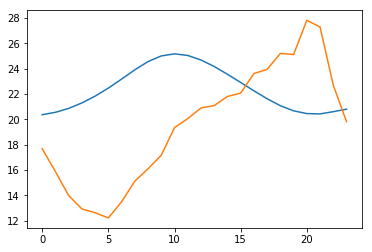

In [274]:
plt.plot(new_results)
plt.plot(real)

In [210]:
X

array([[[  6.70000000e+01,   6.30000000e+01,   6.60000000e+01, ...,
           4.57617000e+03,   1.43100000e+04,   1.00000000e+00],
        [  6.30000000e+01,   6.20000000e+01,   6.70000000e+01, ...,
           2.95220900e+03,   1.33000000e+04,   2.00000000e+00],
        [  6.20000000e+01,   6.20000000e+01,   6.60000000e+01, ...,
           2.79140800e+03,   1.33000000e+04,   3.00000000e+00],
        ..., 
        [  6.20000000e+01,   6.40000000e+01,   6.80000000e+01, ...,
           6.82794600e+03,   1.43100000e+04,   2.30000000e+01],
        [  6.00000000e+01,   6.30000000e+01,   6.80000000e+01, ...,
           7.10774700e+03,   1.34100000e+04,   0.00000000e+00],
        [  6.10000000e+01,   6.40000000e+01,   7.10000000e+01, ...,
           1.61484700e+03,   1.24800000e+04,   1.00000000e+00]],

       [[  6.30000000e+01,   6.20000000e+01,   6.70000000e+01, ...,
           2.95220900e+03,   1.33000000e+04,   2.00000000e+00],
        [  6.20000000e+01,   6.20000000e+01,   6.60000000e+0

In [211]:

scaler = MinMaxScaler()

In [212]:
scaler = scaler.fit(X)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [213]:
X.shape

(2784, 49, 139)

In [214]:
    temp = df.copy()
    temp = temp.drop('TRADEDATE',axis=1)
    temp = temp.drop('RTENERGY',axis=1)
    temp.hourofday = temp.hourofday.dt.seconds/3600




(2832, 143)


In [215]:
scaler = MinMaxScaler()

In [216]:
scaler.fit(temp)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [217]:
scaler.transform(temp)

array([[ 0.43113772,  0.64615385,  0.63461538, ...,  0.30837451,
         0.09291785,  0.04347826],
       [ 0.43712575,  0.58461538,  0.61538462, ...,  0.19228331,
         0.06430595,  0.08695652],
       [ 0.44311377,  0.56923077,  0.61538462, ...,  0.18078822,
         0.06430595,  0.13043478],
       ..., 
       [ 0.26946108,  0.03076923,  0.13461538, ...,  0.8523326 ,
         0.90169972,  0.95652174],
       [ 0.2754491 ,  0.01538462,  0.13461538, ...,  0.82022403,
         0.90169972,  1.        ],
       [ 0.28143713,  0.        ,  0.11538462, ...,  0.78626961,
         0.89660057,  0.        ]])

In [222]:
scaler.inverse_transform([1])

/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (141,)

In [223]:
df.columns.values

array(['TRADEDATE', 'HOUROFWEEK', 'CYWG', 'K2G4', 'KABE', 'KABI', 'KACT',
       'KACY', 'KADS', 'KAKR', 'KAMA', 'KANJ', 'KAOO', 'KARB', 'KARR',
       'KATT', 'KAUS', 'KAVP', 'KAWM', 'KBAZ', 'KBIS', 'KBPT', 'KBRO',
       'KBTR', 'KBWI', 'KCAK', 'KCGI', 'KCGX', 'KCID', 'KCKB', 'KCLE',
       'KCLL', 'KCMH', 'KCMI', 'KCOU', 'KCRP', 'KCRW', 'KCVG', 'KDAL',
       'KDAY', 'KDBQ', 'KDCA', 'KDEC', 'KDET', 'KDFW', 'KDLH', 'KDMH',
       'KDOV', 'KDSM', 'KDTO', 'KDTW', 'KELD', 'KELP', 'KERI', 'KESF',
       'KEVV', 'KEWR', 'KFAR', 'KFDK', 'KFSD', 'KFST', 'KFWA', 'KGAI',
       'KGFK', 'KGLS', 'KGRB', 'KGRR', 'KGWO', 'KHGR', 'KHOU', 'KHZL',
       'KIAD', 'KIAH', 'KILG', 'KIND', 'KINK', 'KINL', 'KIPT', 'KJAN',
       'KJCT', 'KLAN', 'KLBB', 'KLCH', 'KLFK', 'KLIT', 'KLNS', 'KLRD',
       'KLUK', 'KLYH', 'KMAF', 'KMCI', 'KMDT', 'KMDW', 'KMGW', 'KMKE',
       'KMKG', 'KMLI', 'KMLU', 'KMRB', 'KMSN', 'KMSP', 'KMSY', 'KMWL',
       'KODO', 'KORD', 'KORF', 'KOXB', 'KPHL', 'KPIA', 'KPIT', 'KPRX',
   

In [254]:
list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))

/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype timedelta64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [258]:
list_scalers['DAENERGY'].inverse_transform(np.array([0.1]).reshape(-1,1))

array([[ 22.476]])

In [257]:
list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values.reshape(-1,1))

array([[ 22.89],
       [ 20.17],
       [ 19.42],
       ..., 
       [ 26.79],
       [ 23.25],
       [ 21.25]])

In [255]:
listdf.DAENERGY

dt
2017-07-05 01:00:00    0.104037
2017-07-05 02:00:00    0.077516
2017-07-05 03:00:00    0.070203
2017-07-05 04:00:00    0.063573
2017-07-05 05:00:00    0.061135
2017-07-05 06:00:00    0.068058
2017-07-05 07:00:00    0.081123
2017-07-05 08:00:00    0.096236
2017-07-05 09:00:00    0.118077
2017-07-05 10:00:00    0.131045
2017-07-05 11:00:00    0.161954
2017-07-05 12:00:00    0.182040
2017-07-05 13:00:00    0.215971
2017-07-05 14:00:00    0.256435
2017-07-05 15:00:00    0.303237
2017-07-05 16:00:00    0.337559
2017-07-05 17:00:00    0.387676
2017-07-05 18:00:00    0.393916
2017-07-05 19:00:00    0.336876
2017-07-05 20:00:00    0.274863
2017-07-05 21:00:00    0.217531
2017-07-05 22:00:00    0.193545
2017-07-05 23:00:00    0.156689
2017-07-06 00:00:00    0.125975
2017-07-06 01:00:00    0.105109
2017-07-06 02:00:00    0.083463
2017-07-06 03:00:00    0.072835
2017-07-06 04:00:00    0.065815
2017-07-06 05:00:00    0.062207
2017-07-06 06:00:00    0.067278
                         ...   
2017-